## Diplomado en Análisis Espacial de Datos
### Módulo 3: Aplicaciones de las ciencias de datos espaciales en estudios urbanos
#### Profesora: Valeria Ulloa / Alumna: Rocío Valderrama
##### Fecha: 02 de enero de 2024

### Se realiza un ejercicio con los datos de la EOD 2012 del Gran Santiago. Se trabaja con un .csv en donde Valeria agrupó las tablas que la componen, usando el código común entre ellas (hogar).

In [74]:
%time 

import geopandas as gpd
from shapely import geometry
from shapely.geometry import MultiPolygon, Polygon, LineString, Point, MultiPoint
import IPython.display as display
import utm
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from datetime import datetime
import copy
import warnings
warnings.filterwarnings('ignore')
import osmnx as ox
import folium
import folium.plugins
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as ctx
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
wd = os.getcwd()
wd

'C:\\Users\\rovci\\Downloads\\Python\\diplomado\\Módulo 3_ Aplicaciones de las ciencias de datos espaciales en estudios urbanos\\clase_39'

In [3]:
# Cargar csv
viajes = (pd.read_csv(f'{wd}/eod_santiago_2012.csv')
            .assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
            .assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
            .assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
            )
viajes.sample(2)

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,HoraDeInicio,Sexo,TramoIngreso,Ocupacion,JornadaTrabajo,Relacion,origin_latitude,origin_longitude,destination_latitude,destination_longitude,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
8187,1266710402,126671,12667104,1,Santiago,Independencia,Centro,Norte,20,170,346795.750,6298791.0,344538.0313,6301083.0,volver a casa,1.0,NaN,3,Bus TS,2,1,0 days 18:30:00.000000000,0 days 19:20:00.000000000,18:55,50.0,2.0,Punta Tarde (17:31 - 20:30),4.0,2.0,1.000000,NaN,NaN,NaN,NaN,0.0,Bip!,3217,4550,0,18.5,Mujer,Entre 200.001 y 400.000 pesos,Empleado u obrero del sector privado,Jornada completa (40 o más horas semanales),Hijo o Hija,-33.439345,-70.648152,-33.418356,-70.672035,Norte,INDEPENDENCIA,-33.418358,-70.672035,4,0,1,0,866526,170,0 days 18:30:00,0 days 19:20:00,50.0
69345,2693710102,269371,26937101,1,Santiago,Santiago,Centro,Centro,34,48,347517.125,6298462.5,346942.3125,6297983.5,volver a casa,3.0,NaN,7,Taxi,1,1,0 days 10:00:00.000000000,0 days 10:15:00.000000000,10:08,15.0,1.0,Fuera de Punta 1 (10:01 - 12:00),0.0,0.0,1.482104,NaN,NaN,NaN,NaN,0.0,Taxi,748,1054,0,10.0,Hombre,Entre 400.001 y 800.000 pesos,Empleado u obrero del sector privado,Jornada completa (40 o más horas semanales),Jefe(a) de Hogar,-33.442410,-70.640450,-33.446647,-70.646713,Centro,SANTIAGO,-33.446648,-70.646713,1,0,0,0,545135,48,0 days 10:00:00,0 days 10:15:00,15.0


In [4]:
viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74166 entries, 0 to 74165
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   Viaje                     74166 non-null  int64          
 1   Hogar                     74166 non-null  int64          
 2   Persona                   74166 non-null  int64          
 3   Etapas                    74166 non-null  int64          
 4   ComunaOrigen              74166 non-null  object         
 5   ComunaDestino             74166 non-null  object         
 6   SectorOrigen              74132 non-null  object         
 7   SectorDestino             74132 non-null  object         
 8   ZonaOrigen                74166 non-null  int64          
 9   ZonaDestino               74166 non-null  int64          
 10  OrigenCoordX              74166 non-null  float64        
 11  OrigenCoordY              74166 non-null  float64        
 12  Dest

In [34]:
# viajes['FactorLaboralNormal'].sum()

In [50]:
#gdf = gpd.GeoDataFrame(viajes.copy(), geometry=gpd.points_from_xy(viajes['destination_latitude'],
                                                                    viajes['destination_longitude']), crs='EPSG:4326')

In [52]:
#f = folium.Figure(width=1000, height=500)
#map = folium.Map(location=[gdf['destination_longitude'].mean(), gdf['destination_latitude'].mean()],
                 tiles='CartoDB positron', zoom_start=14).add_to(f)
#map

IndentationError: unexpected indent (213763434.py, line 3)

In [65]:
# Se genera un GeoDataFrame con la tabla
crs = 4326
gdf = gpd.GeoDataFrame(viajes, geometry=gpd.points_from_xy(viajes.destination_longitude, viajes.destination_latitude), crs='EPSG:32719')
gdf = gdf.to_crs(epsg=crs)

In [1]:
# Cargar un shape

shp_zonas = gpd.read_file(f'{wd}/Zonas_769_UTM.shp')

NameError: name 'gpd' is not defined

In [59]:
shp_zonas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          762 non-null    int64   
 1   AREA        762 non-null    float64 
 2   ID_769      762 non-null    int64   
 3   ID_718      762 non-null    int64   
 4   ID_718X     94 non-null     object  
 5   ID_690      762 non-null    int64   
 6   COMUNA      762 non-null    object  
 7   RENOVACION  762 non-null    object  
 8   TIPO        762 non-null    object  
 9   DESAGREGAD  762 non-null    int64   
 10  Area_1      762 non-null    float64 
 11  geometry    762 non-null    geometry
dtypes: float64(2), geometry(1), int64(5), object(4)
memory usage: 71.6+ KB


In [61]:
shp_zonas.sample(3)

,ID,AREA,ID_769,ID_718,ID_718X,ID_690,COMUNA,RENOVACION,TIPO,DESAGREGAD,Area_1,geometry
233,701,6.44,475,475,NaN,475,Lo Barnechea,Sin Renovacion,INTERNA,0,6.436763e+06,"POLYGON ((359469.806 6308729.544, 359496.431 6..."
216,177,1.94,190,190,NaN,190,Las Condes,Sin Renovacion,INTERNA,0,1.940960e+06,"POLYGON ((358822.023 6306363.944, 359316.223 6..."
126,737,0.30,311,311,311-A,311,San Ramon,Sin Renovacion,INTERNA,1,2.981179e+05,"POLYGON ((348066.850 6286461.927, 348033.952 6..."


<Axes: >

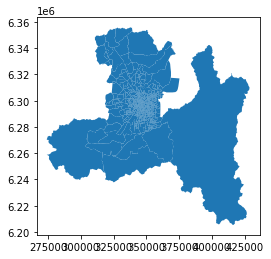

In [62]:
shp_zonas.plot()

CPLE_AppDefinedError: latitude max < latitude min.

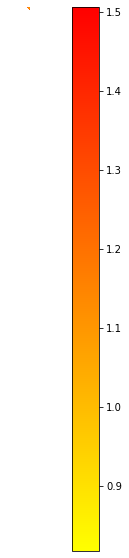

In [75]:
# Se genera un mapa estático
ax = gdf.plot(column='FactorLaboralNormal', cmap='autumn_r',
              figsize=(15,10), legend=True, alpha=0.6, zorder=2, marker='.')
gplt.polyplot(shp_zonas, ax=ax, zorder=1)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.Positron, crs=f'EPSG:{crs}')

In [56]:
## Lectura shape zonas EOD

shape_name = 'Zonas_769_UTM.shp'
shp_zonas = gpd.read_file(f'{wd}/Zonas_769_UTM.shp')

#shp_zonas = gpd.read_file(f'{work_directory}/shape_zonas/{shape_name}')
shp_zonas = shp_zonas.to_crs(epsg=crs)

NameError: name 'crs' is not defined

In [5]:
# viajes con distancia mayor a 300 metros
viajes = viajes[(viajes.DistManhattan >= 300)
                # sacamos las otras actividades (especifique)
                & (viajes.Proposito != 'Otra actividad (especifique)')
                # estamos analizando la RM así que sacamos viajes fuera de ésta
                & (~viajes.SectorOrigen.isin(['Exterior a RM']))
                & (~viajes.Sector.isin(['Exterior a RM']))
                & (~viajes.SectorDestino.isin(['Exterior a RM']))
                # para los modos de viaje, tampoco se indica qué es "otros"
                & ~(viajes.ModoDifusion == 'Otros')].copy()

In [6]:
viajes.sample(2)

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,HoraDeInicio,Sexo,TramoIngreso,Ocupacion,JornadaTrabajo,Relacion,origin_latitude,origin_longitude,destination_latitude,destination_longitude,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
62637,2541710102,254171,25417101,1,San Bernardo,San Bernardo,Sur,Sur,760,774,341707.375,6281511.5,342266.3438,6280475.5,volver a casa,3.0,NaN,8,Caminata,5,2,0 days 12:00:00.000000000,0 days 12:30:00.000000000,12:15,30.0,1.0,"Fuera de Punta 2 (9:01 - 10:00, 12:01 - 17:30,...",30.0,8.0,NaN,NaN,NaN,1.482104,NaN,NaN,Caminata,1177,1595,0,12.0,Mujer,Menos de 200.000 pesos,NaN,NaN,Jefe(a) de Hogar,-33.594391,-70.705927,-33.603814,-70.700089,Sur,SAN BERNARDO,-33.603813,-70.700088,3,0,0,0,180748,774,0 days 12:00:00,0 days 12:30:00,30.0
58570,2434100102,243410,24341001,2,Providencia,Quinta Normal,Oriente,Poniente,505,558,351630.000,6299519.0,340409.6875,6301010.0,volver a casa,1.0,NaN,3;2,Bus TS,2,1,0 days 15:00:00.000000000,0 days 17:30:00.000000000,16:15,150.0,5.0,"Fuera de Punta 2 (9:01 - 10:00, 12:01 - 17:30,...",3.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,Bip!,11319,12711,0,15.0,Mujer,Menos de 200.000 pesos,Servicio doméstico puertas afuera,"Jornada parcial (menos de 40 horas semanales, ...",Jefe(a) de Hogar,-33.433462,-70.596043,-33.418408,-70.716432,Poniente,QUINTA NORMAL,-33.418409,-70.716432,1,0,0,0,200000,558,0 days 15:00:00,0 days 17:30:00,150.0


In [40]:
viajes = viajes[viajes['Proposito'] == 'visitar a alguien', 'buscar o dejar a alguien', 'buscar o dejar algo', 'de compras','trámites'

SyntaxError: incomplete input (2010345507.py, line 1)

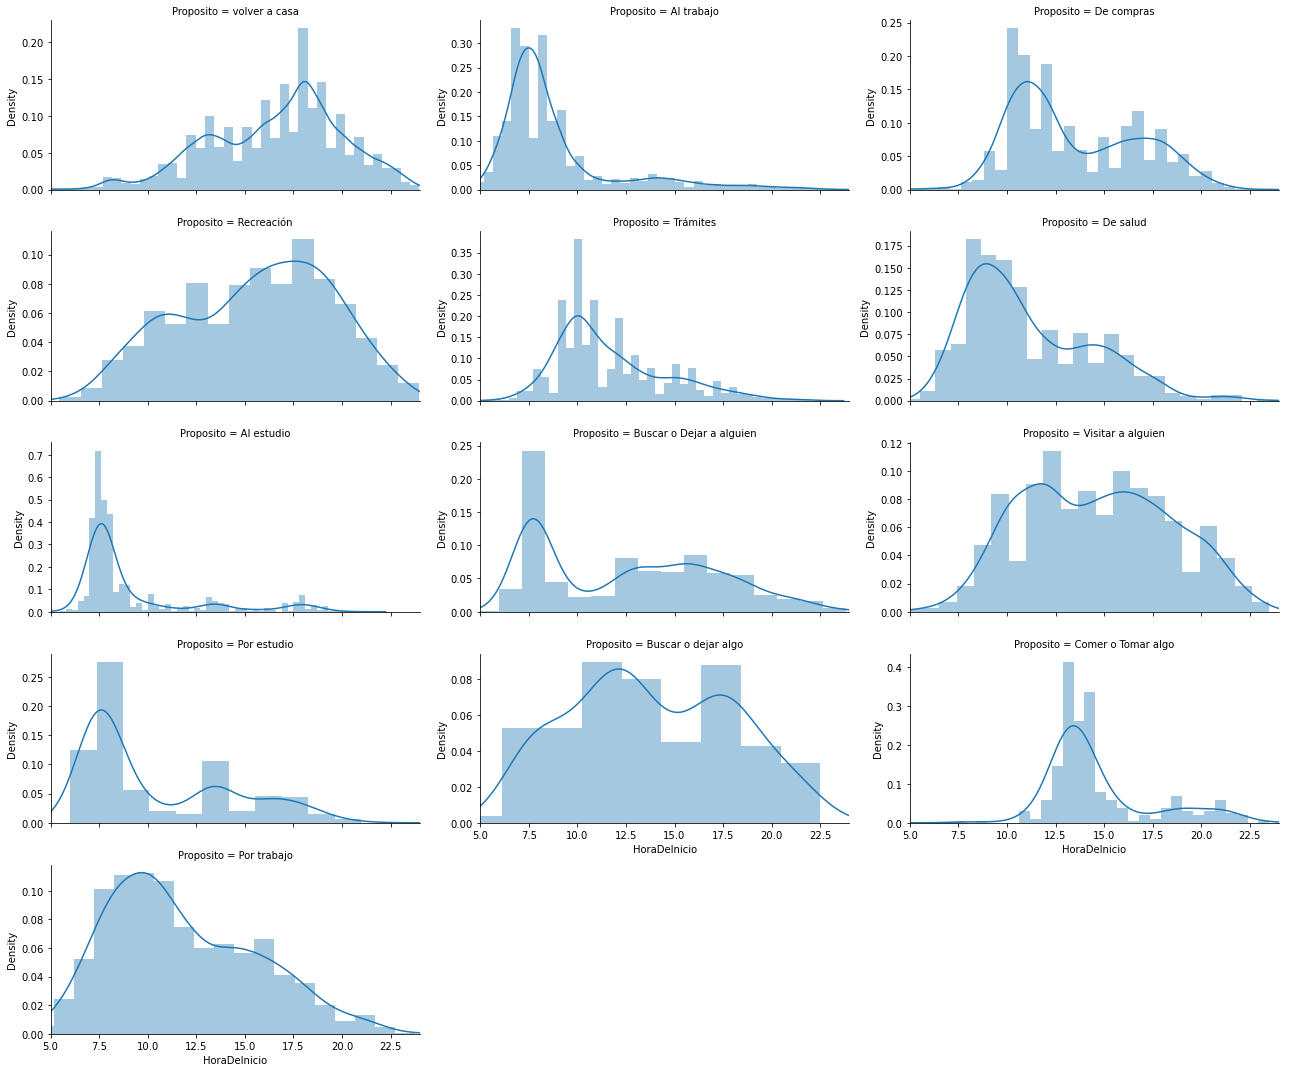

In [7]:
g = sb.FacetGrid(data=viajes, col='Proposito', col_wrap=3, aspect=2, sharey=False)
g.map(sb.distplot, 'HoraDeInicio')
g.add_legend()
g.set(xlim=[5,24])

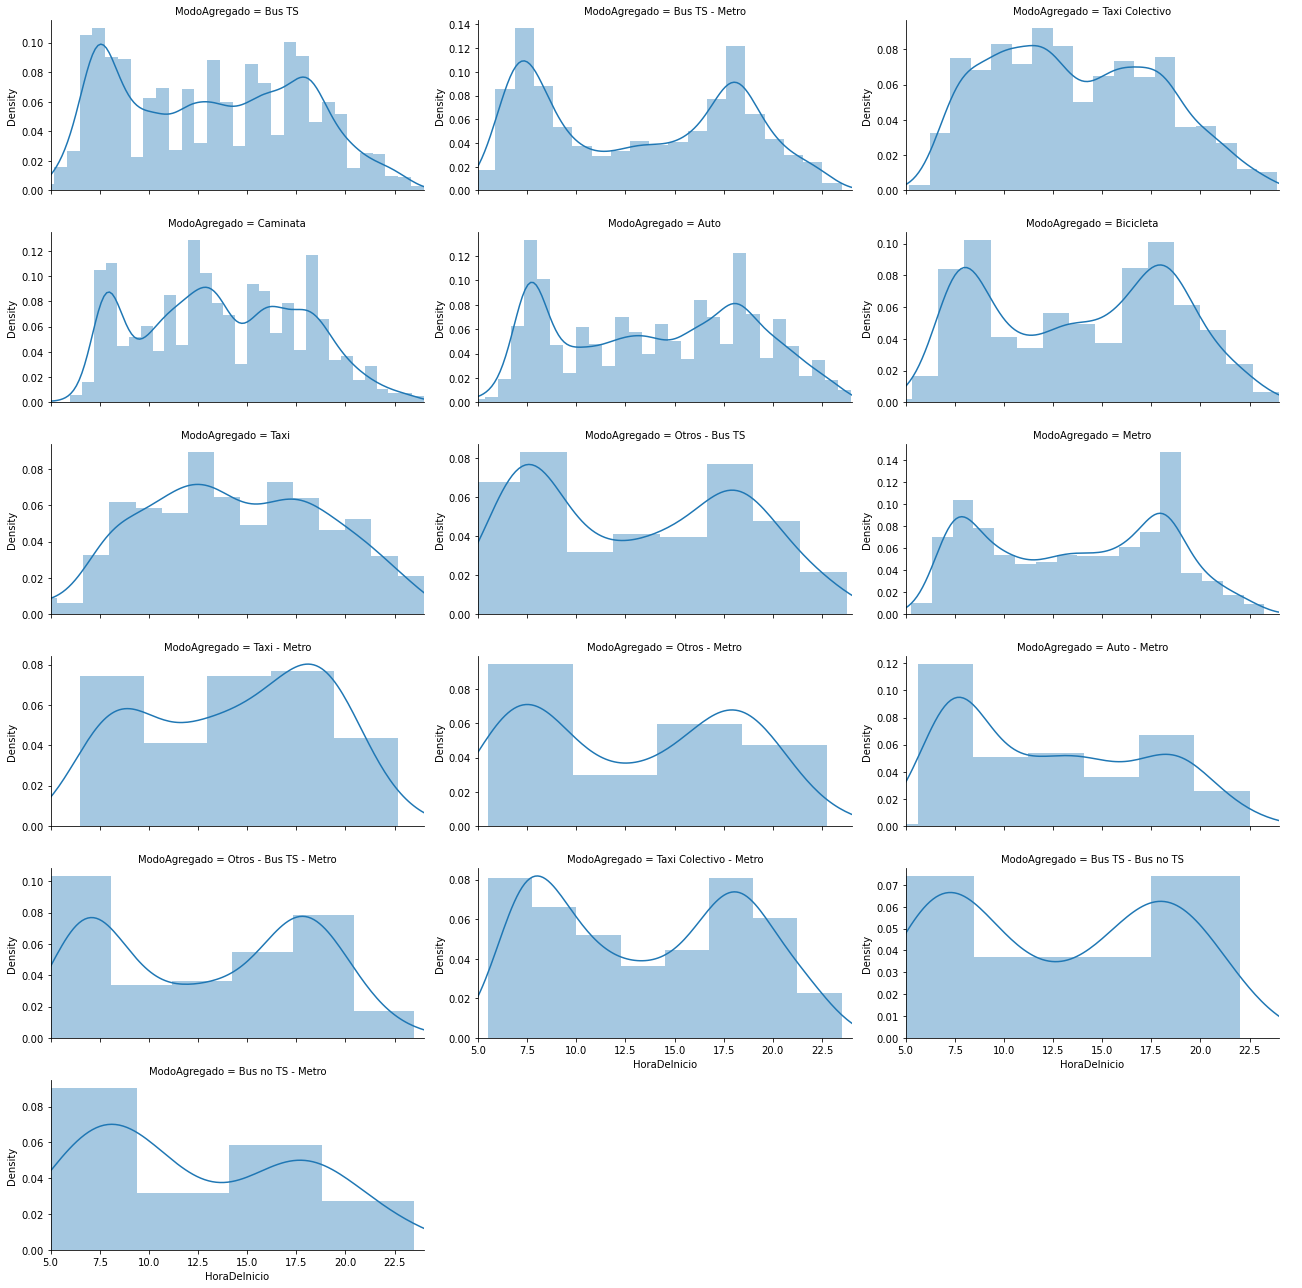

In [8]:
g = sb.FacetGrid(data=viajes, col='ModoAgregado', col_wrap=3, aspect=2, sharey=False)
g.map(sb.distplot, 'HoraDeInicio')
g.add_legend()
g.set(xlim=[5,24])

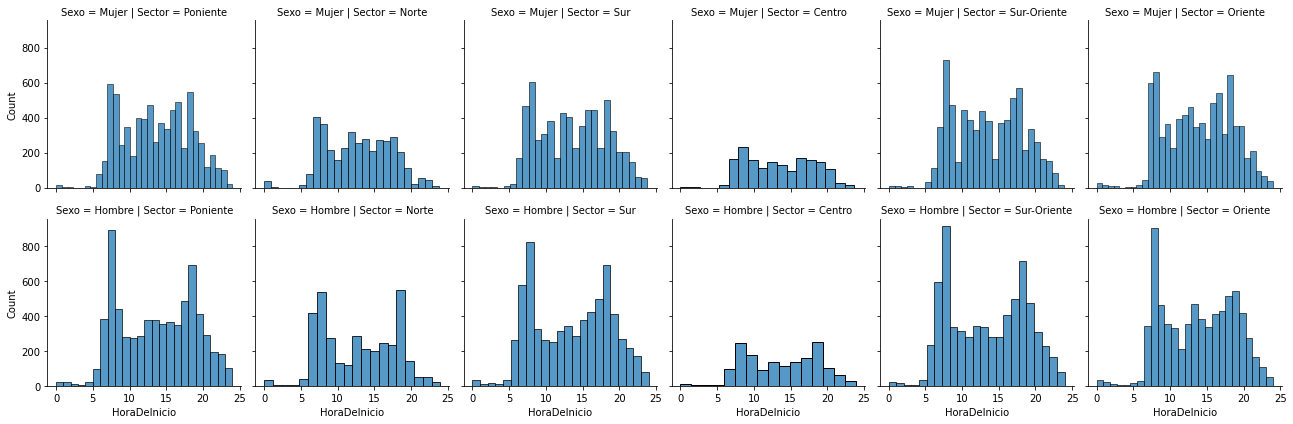

In [10]:
g = sb.FacetGrid(viajes, col="Sector",  row="Sexo")
g.map_dataframe(sb.histplot, x="HoraDeInicio")

In [11]:
df_MATRIX = viajes.pivot_table(values='HoraDeInicio', index="Sexo", columns='ModoAgregado',
           fill_value=0, aggfunc=len)

In [12]:
df_MATRIX

ModoAgregado,Auto,Auto - Metro,Bicicleta,Bus TS,Bus TS - Bus no TS,Bus TS - Metro,Bus no TS - Metro,Caminata,Metro,Otros - Bus TS,Otros - Bus TS - Metro,Otros - Metro,Taxi,Taxi - Metro,Taxi Colectivo,Taxi Colectivo - Metro
Sexo,,,,,,,,,,,,,,,,
Hombre,10924,128,1635,7605,58,3839,25,4080,2499,238,109,50,506,60,686,229
Mujer,8669,137,542,9279,26,3950,22,5895,2314,255,139,43,924,61,1484,342


Text(0.5, 69.0, 'Modo Agregado')

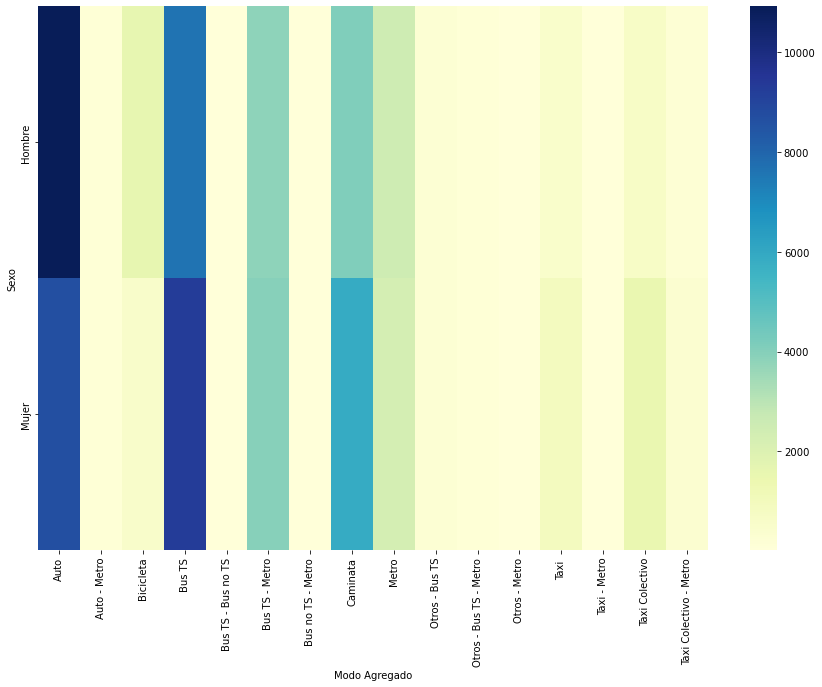

In [14]:
plt.figure(figsize=(15,10))
sb.heatmap(df_MATRIX, cmap="YlGnBu")
fig = plt.gcf()

plt.xlabel('Modo Agregado', fontsize= 10)
#plt.ylabel('Comunas de destino', fontsize=10)

In [ ]:
# Existe mayor cantidad de hombres que utilizan el auto como modo principal de transporte, mientras que las mujeres hacen mayor 
# uso del bus

In [15]:
df_MATRIX = viajes.pivot_table(values='FactorLaboralNormal', index="Sector", columns='ModoAgregado',
           fill_value=0, aggfunc=len)

Text(0.5, 69.0, 'Modo Agregado')

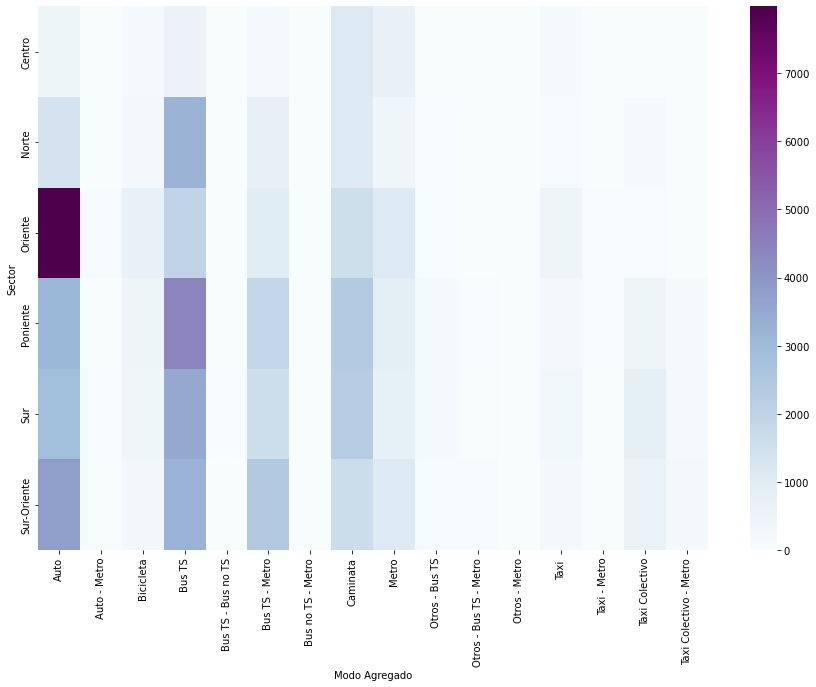

In [16]:
plt.figure(figsize=(15,10))
sb.heatmap(df_MATRIX, cmap="BuPu")
fig = plt.gcf()

plt.xlabel('Modo Agregado', fontsize= 10)
#plt.ylabel('Comunas de destino', fontsize=10)

In [ ]:
# En el heatmap anterior se visualiza claramente que el vehículo particular es dominate en el sector oriente de la región, 
# por el contrario, en el poninete predomina el transporte público, en particular el bus.

<Axes: xlabel='Sexo', ylabel='Sector'>

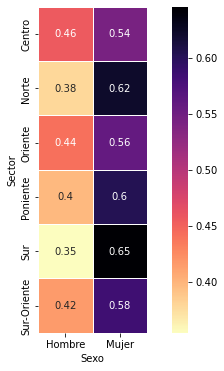

In [23]:
modo_camin = (viajes[viajes.ModoAgregado == 'Caminata']
       .groupby(['Sector', 'Sexo'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Sector', values='FactorLaboralNormal', columns='Sexo')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(9,6))
sb.heatmap(modo_camin, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

In [ ]:
# En el heatmao anterior se observa que respecto al modo caminata, el separarlo por sexo, en todos los sectores de la región 
# se aprecia que la mujer es la que más recurre más a este modo, destacándose el sector sur, seguido por el norte.

<Axes: xlabel='Sexo', ylabel='Sector'>

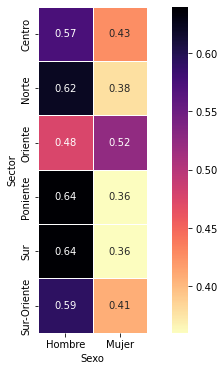

In [24]:
modo_auto = (viajes[viajes.ModoAgregado == 'Auto']
       .groupby(['Sector', 'Sexo'])
       .aggregate({'FactorLaboralNormal': 'sum'})
       .reset_index()
       .pivot_table(index='Sector', values='FactorLaboralNormal', columns='Sexo')
       .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
       )

plt.figure(figsize=(9,6))
sb.heatmap(modo_auto, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

In [ ]:
# Por el contrario, si separamos el modo auto por sexo, se observa que son los hombres los que más usan este modo de transporte
# sobretodo en el sector poniente y sur.

In [17]:
df_MATRIX = viajes.pivot_table(values='FactorLaboralNormal', index="Sexo", columns='Proposito',
           fill_value=0, aggfunc=len)

Text(0.5, 69.0, 'Fecha')

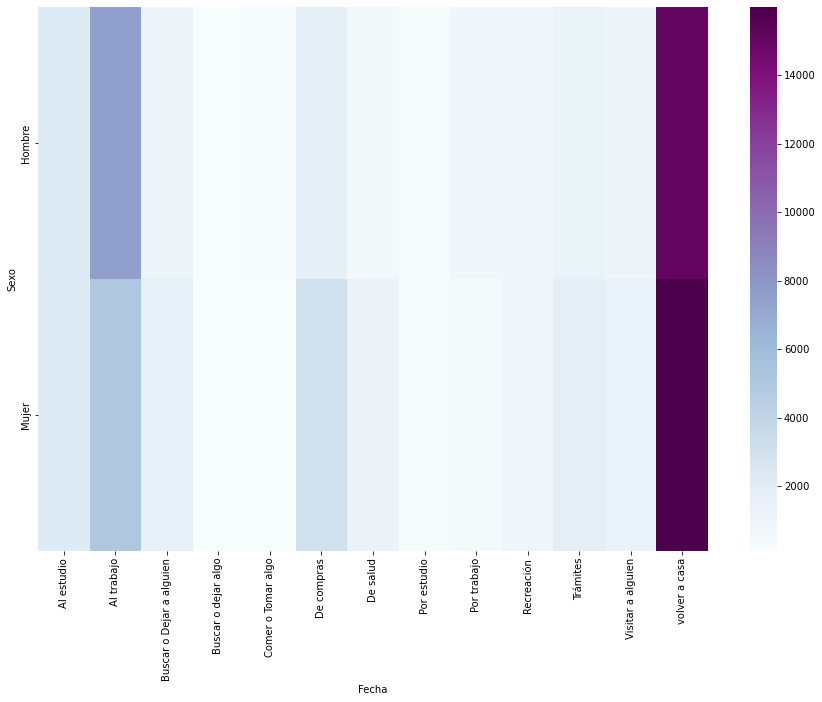

In [20]:
plt.figure(figsize=(15,10))
sb.heatmap(df_MATRIX, cmap="BuPu")
fig = plt.gcf()

plt.xlabel('Fecha', fontsize= 10)
#plt.ylabel('Comunas de destino', fontsize=10)

In [ ]:
# Respecto al propósito, tanto los hombres como las mujeres utilizan el auto como modo principal para ir al trabajo 
# (dejando fuera los viajes con propósito "volver a casa" ), en donde los hombres presentan mayor cantidad de viajes. 
# Cabe destacar que luego dle propósito "Al trabajo", en cantidad de viajes destaca el "de compras", realizado 
# mayoritariamnete por mujeres.

In [ ]:
#para normalizar debo usar este código...

#se normalizan las columnas con el metodo min-max. El resultado de la normalización resta el valor mínimo de Dataframe 
#y lo divide por la diferencia entre el valor más alto y el más bajo de la columna correspondiente.

def minmax_norm(df_input):
    return (secciones_matriz - secciones_matriz.min()) / ( secciones_matriz.max() - secciones_matriz.min())

df_minmax_norm = minmax_norm(secciones_matriz)

print(df_minmax_norm)